In [1]:
import os
import sys
import yaml
import copy
import numpy as np
import pandas as pd
import xarray as xr

In [2]:
sys.path.insert(0, os.path.realpath('../libs/'))
import graph_utils as gu
#import verif_utils as vu

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
import cmaps
# graph tools
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.gridspec as gridspec
import matplotlib.colors as colors
import matplotlib.colorbar as cbar
import matplotlib.ticker as ticker
from matplotlib.ticker import ScalarFormatter
from matplotlib.colors import LinearSegmentedColormap
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

import cartopy.crs as ccrs
import cartopy.mpl.geoaxes
import cartopy.feature as cfeature

%matplotlib inline

In [5]:
dict_loc = {
    'Pituffik': (76.4, -68.575),
    'Fairbanks': (64.75, -147.4),
    'Guam': (13.475, 144.75),
    'Yuma_PG': (33.125, -114.125),
    'Fort_Bragg': (35.05, -79.115),
}

stn_names = list(dict_loc.keys())

In [6]:
def lon_to_0360(lon):
    return lon % 360.0

def subset_stn(ds_ACC_all: xr.Dataset, key: str, method: str = "nearest") -> xr.DataArray:
    sites = list(dict_loc.keys())
    lats = xr.DataArray([dict_loc[s][0] for s in sites], dims="site", coords={"site": sites})
    lons = xr.DataArray([lon_to_0360(dict_loc[s][1]) for s in sites], dims="site", coords={"site": sites})

    # result dims: (site, lead_year)
    return ds_ACC_all[key].sel(lat=lats, lon=lons, method=method)


In [7]:
scale_param = '110m'

PROVINCE = cfeature.NaturalEarthFeature(
    category='cultural',
    name='admin_1_states_provinces_lines',
    scale=scale_param,
    facecolor='none')

def map_gridline_opt(ax):
    '''
    Customize cartopy map gridlines
    '''
    ax.add_feature(cfeature.BORDERS.with_scale(scale_param), linestyle='-', linewidth=0.5, zorder=7)
    ax.add_feature(PROVINCE, edgecolor='k', linestyle='-', linewidth=0.5, zorder=7)
    ax.add_feature(cfeature.COASTLINE.with_scale(scale_param ), edgecolor='k', linewidth=0.5, zorder=5)
    ax.spines['geo'].set_linewidth(2.5)
    return ax

### 2-m Temp mean

In [8]:
leads = [0, 4, 9]
vmin, vmax = 0.0, 0.6
cmap = gu.precip_cmap(return_rgb=False, land_map=False)

In [9]:
fn = '/glade/derecho/scratch/ksha/EPRI_data/METRICS_GLOBE/CESM_minmax_ACC.zarr'
fn_detrend = '/glade/derecho/scratch/ksha/EPRI_data/METRICS_GLOBE/CESM_minmax_ACC_detrend.zarr'

ds_ACC_all = xr.open_zarr(fn)
ds_ACC_detrend = xr.open_zarr(fn_detrend)

x = ds_ACC_all['lon'].values
y = ds_ACC_all['lat'].values
lon, lat = np.meshgrid(x, y)

In [10]:
cmap = gu.precip_cmap(return_rgb=False, land_map=False)

my_colors = gu.ksha_color_set_summon(color_set=0)
cyan = np.array([0.4, 0.8, 1, 1])
blue = my_colors['blue']
red = my_colors['red']
orange = my_colors['orange']

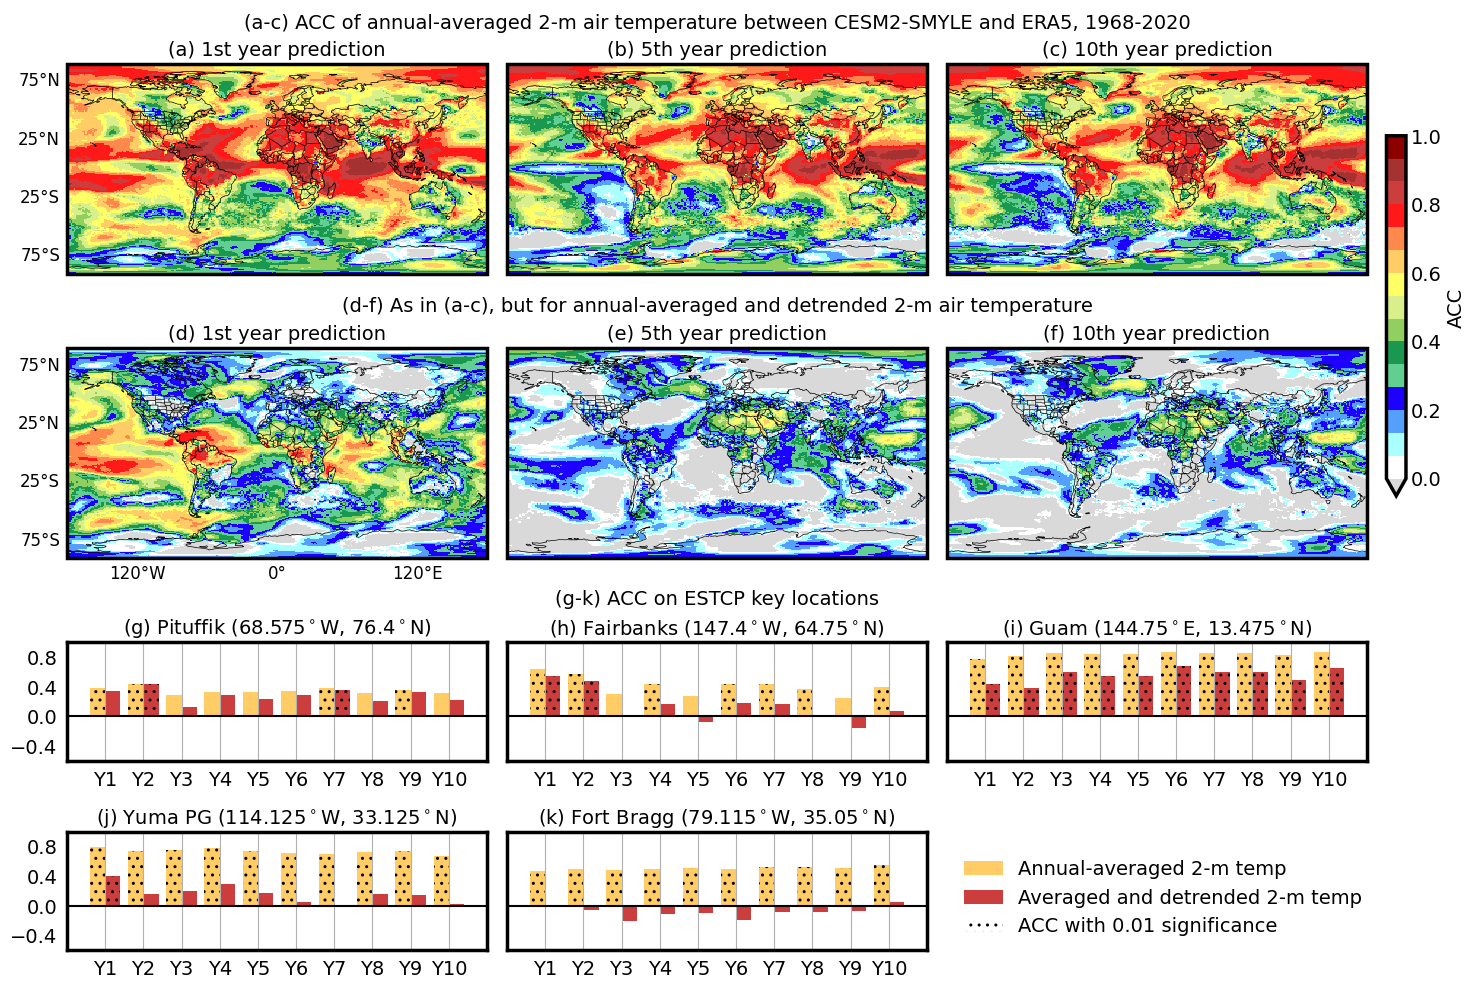

In [11]:
key = 'TREFHT_mean' #['TREFHT_mean', 'TREFHTMX_max', 'PRECT_mean', 'PRECT_max']
np_ACC = ds_ACC_all[key].values
np_ACC_pval = ds_ACC_all[key+'_pval'].values
np_ACC_detrend = ds_ACC_detrend[key+'_detrend'].values
np_ACC_detrend_pval = ds_ACC_detrend[key+'_detrend_pval'].values

ds_stn = subset_stn(ds_ACC_all, key=key)
ds_stn_pval = subset_stn(ds_ACC_all, key=key+'_pval')
ds_stn_detrend = subset_stn(ds_ACC_detrend, key=key+'_detrend')
ds_stn_detrend_pval = subset_stn(ds_ACC_detrend, key=key+'_detrend_pval')

np_stn = ds_stn.values
np_stn_pval = ds_stn_pval.values
np_stn_detrend = ds_stn_detrend.values
np_stn_detrend_pval = ds_stn_detrend_pval.values

proj_ = ccrs.PlateCarree()
map_extent = [-180, 180, -90, 90]

fig = plt.figure(figsize=(13, 9))
gs = gridspec.GridSpec(7, 6, height_ratios=[1, 0.2, 1, 0.3, 0.5, 0.3, 0.5], width_ratios=[1,]*6)

AX_maps = []
AX_maps.append(plt.subplot(gs[0, 0:2], projection=proj_))
AX_maps.append(plt.subplot(gs[0, 2:4], projection=proj_))
AX_maps.append(plt.subplot(gs[0, 4:6], projection=proj_))
AX_maps.append(plt.subplot(gs[2, 0:2], projection=proj_))
AX_maps.append(plt.subplot(gs[2, 2:4], projection=proj_))
AX_maps.append(plt.subplot(gs[2, 4:6], projection=proj_))

AX_lines = []
AX_lines.append(plt.subplot(gs[4, 0:2]))
AX_lines.append(plt.subplot(gs[4, 2:4]))
AX_lines.append(plt.subplot(gs[4, 4:6]))

AX_lines.append(plt.subplot(gs[6, 0:2]))
AX_lines.append(plt.subplot(gs[6, 2:4]))

fake_x = np.arange(10)
for ax in AX_lines:
    ax = gu.ax_decorate_box(ax)
    ax.tick_params(labelbottom=True)
    ax.set_ylim([-0.6, 1])
    ax.set_yticks([-0.4, 0, 0.4, 0.8])
    ax.set_xlim(-1, fake_x[-1] + 1)
    ax.set_xticks(fake_x)
    ax.set_xticklabels(['Y1', 'Y2', 'Y3', 'Y4', 'Y5', 'Y6', 'Y7', 'Y8', 'Y9', 'Y10'])
    ax.grid(axis='x')

AX_lines[0].tick_params(labelleft=True)
AX_lines[3].tick_params(labelleft=True)

for i_ax, ax in enumerate(AX_maps):
    ax.set_extent(map_extent, crs=proj_)
    ax = map_gridline_opt(ax)
    if i_ax == 0 or i_ax == 3:
        GL = ax.gridlines(
            crs=ccrs.PlateCarree(),
            draw_labels=True, x_inline=False, y_inline=False,
            color='k', linewidth=0, linestyle=':', zorder=5
        )
        GL.top_labels = None
        GL.right_labels = None
        if i_ax == 0:
            GL.bottom_labels = None
        GL.xlabel_style = {'size': 12}
        GL.ylabel_style = {'size': 12}
        GL.xlocator = ticker.FixedLocator([-120, 0, 120])
        GL.ylocator = ticker.FixedLocator([-75, -25, 25, 75])


plt.subplots_adjust(0, 0, 1, 1, hspace=0.0, wspace=0.1)

for i_lead, lead in enumerate(leads):
    CS = AX_maps[i_lead].pcolormesh(
        lon, lat, np_ACC[lead, ...], 
        vmin=0, vmax=1.0, cmap=cmap, 
        transform=ccrs.PlateCarree()
    )
    
    # mask_pval = np_ACC_pval[lead, ...] < 0.01
    # AX_maps[i_lead].contourf(
    #     lon, lat, mask_pval.astype(int),
    #     levels=[0.99, 1.01],
    #     colors="none",
    #     hatches=[".."],
    #     transform=ccrs.PlateCarree()
    # )
    
    AX_maps[3+i_lead].pcolormesh(
        lon, lat, np_ACC_detrend[lead, ...], 
        vmin=0, vmax=1.0, cmap=cmap, 
        transform=ccrs.PlateCarree()
    )
    
    # mask_detrend_pval = np_ACC_detrend_pval[lead, ...] < 0.01
    # AX_maps[3+i_lead].contourf(
    #     lon, lat, mask_detrend_pval.astype(int),
    #     levels=[0.99, 1.01],
    #     colors="none",
    #     hatches=[".."],
    #     transform=ccrs.PlateCarree()
    # )

width = 0.40
x1 = fake_x - width/2   # left bars
x2 = fake_x + width/2   # right bars
for i_stn, stn in enumerate(stn_names):
    ax = AX_lines[i_stn]

    ax.axhline(0, xmin=0, xmax=1, linewidth=1.5, color='k', linestyle='-')
    bars1 = ax.bar(x1, np_stn[:, i_stn], width=width, color=orange, edgecolor="none")
    mask_pval = np_stn_pval[:, i_stn] < 0.01
    for rect, m in zip(bars1, mask_pval):
        if m:
            rect.set_hatch("..")
            rect.set_edgecolor("k")
            rect.set_linewidth(0.0)
            
    
    bars2 = ax.bar(x2, np_stn_detrend[:, i_stn], width=width, color=red, edgecolor="none")
    mask_detrend_pval = np_stn_detrend_pval[:, i_stn] < 0.01
    for rect, m in zip(bars2, mask_detrend_pval):
        if m:
            rect.set_hatch("..")
            rect.set_edgecolor("k")
            rect.set_linewidth(0.0)

AX_maps[0].set_title('(a) 1st year prediction', fontsize=14)
AX_maps[1].set_title('(b) 5th year prediction', fontsize=14)
AX_maps[2].set_title('(c) 10th year prediction', fontsize=14)
AX_maps[3].set_title('(d) 1st year prediction', fontsize=14)
AX_maps[4].set_title('(e) 5th year prediction', fontsize=14)
AX_maps[5].set_title('(f) 10th year prediction', fontsize=14)

ax_base = fig.add_axes([1.015, 0.505, 0.05, 0.4])#
ax_base.tick_params(
    axis='both', left=False, top=False, right=False, bottom=False, 
    labelleft=False, labeltop=False, labelright=False, labelbottom=False
)
cax = inset_axes(ax_base, width='30%', height='100%', borderpad=0, loc=2)
CBar = plt.colorbar(CS, orientation='vertical', extend='min', cax=cax) # ticks=[...]
CBar.ax.tick_params(axis='y', labelsize=14, direction='in', length=0)
CBar.outline.set_linewidth(2.5)
CBar.ax.set_ylabel('ACC', fontsize=14)

ax_title1 = fig.add_axes([0.0, 1.015, 1.0, 0.03])
ax_title1.text(
    0.5, 0.5, 
    '(a-c) ACC of annual-averaged 2-m air temperature between CESM2-SMYLE and ERA5, 1968-2020', 
    fontsize=14, va='center', ha='center', transform=ax_title1.transAxes
)

ax_title2 = fig.add_axes([0.0, 0.7, 1.0, 0.03])
ax_title2.text(
    0.5, 0.5, 
    '(d-f) As in (a-c), but for annual-averaged and detrended 2-m air temperature', 
    fontsize=14, va='center', ha='center', transform=ax_title2.transAxes
)

ax_title3 = fig.add_axes([0.0, 0.375, 1.0, 0.03])
ax_title3.text(
    0.5, 0.5, 
    '(g-k) ACC on ESTCP key locations', 
    fontsize=14, va='center', ha='center', transform=ax_title3.transAxes
)

AX_lines[0].set_title('(g) Pituffik (68.575$^\circ$W, 76.4$^\circ$N)', fontsize=14)
AX_lines[1].set_title('(h) Fairbanks (147.4$^\circ$W, 64.75$^\circ$N)', fontsize=14)
AX_lines[2].set_title('(i) Guam (144.75$^\circ$E, 13.475$^\circ$N)', fontsize=14)
AX_lines[3].set_title('(j) Yuma PG (114.125$^\circ$W, 33.125$^\circ$N)', fontsize=14)
AX_lines[4].set_title('(k) Fort Bragg (79.115$^\circ$W, 35.05$^\circ$N)', fontsize=14)

handle_legneds1 = []
handle_legneds1.append(patches.Patch(facecolor=orange, linewidth=0, label=' '))
handle_legneds1.append(patches.Patch(facecolor=red, linewidth=0, label=' '))
handle_legneds1.append(patches.Patch(facecolor='none', hatch='..', linewidth=0, label=' '))

ax_lg1 = fig.add_axes([0.68, 0.01, 0.33, 0.11])
LG1 = ax_lg1.legend(
    handle_legneds1, 
    ['Annual-averaged 2-m temp', 'Averaged and detrended 2-m temp', 'ACC with 0.01 significance'], 
    bbox_to_anchor=(1, 1), ncol=1, prop={'size':14}
)

LG1 = gu.lg_box(LG1)
ax_lg1.set_axis_off()
ax_base.set_axis_off()
ax_title1.set_axis_off()
ax_title2.set_axis_off()
ax_title3.set_axis_off()

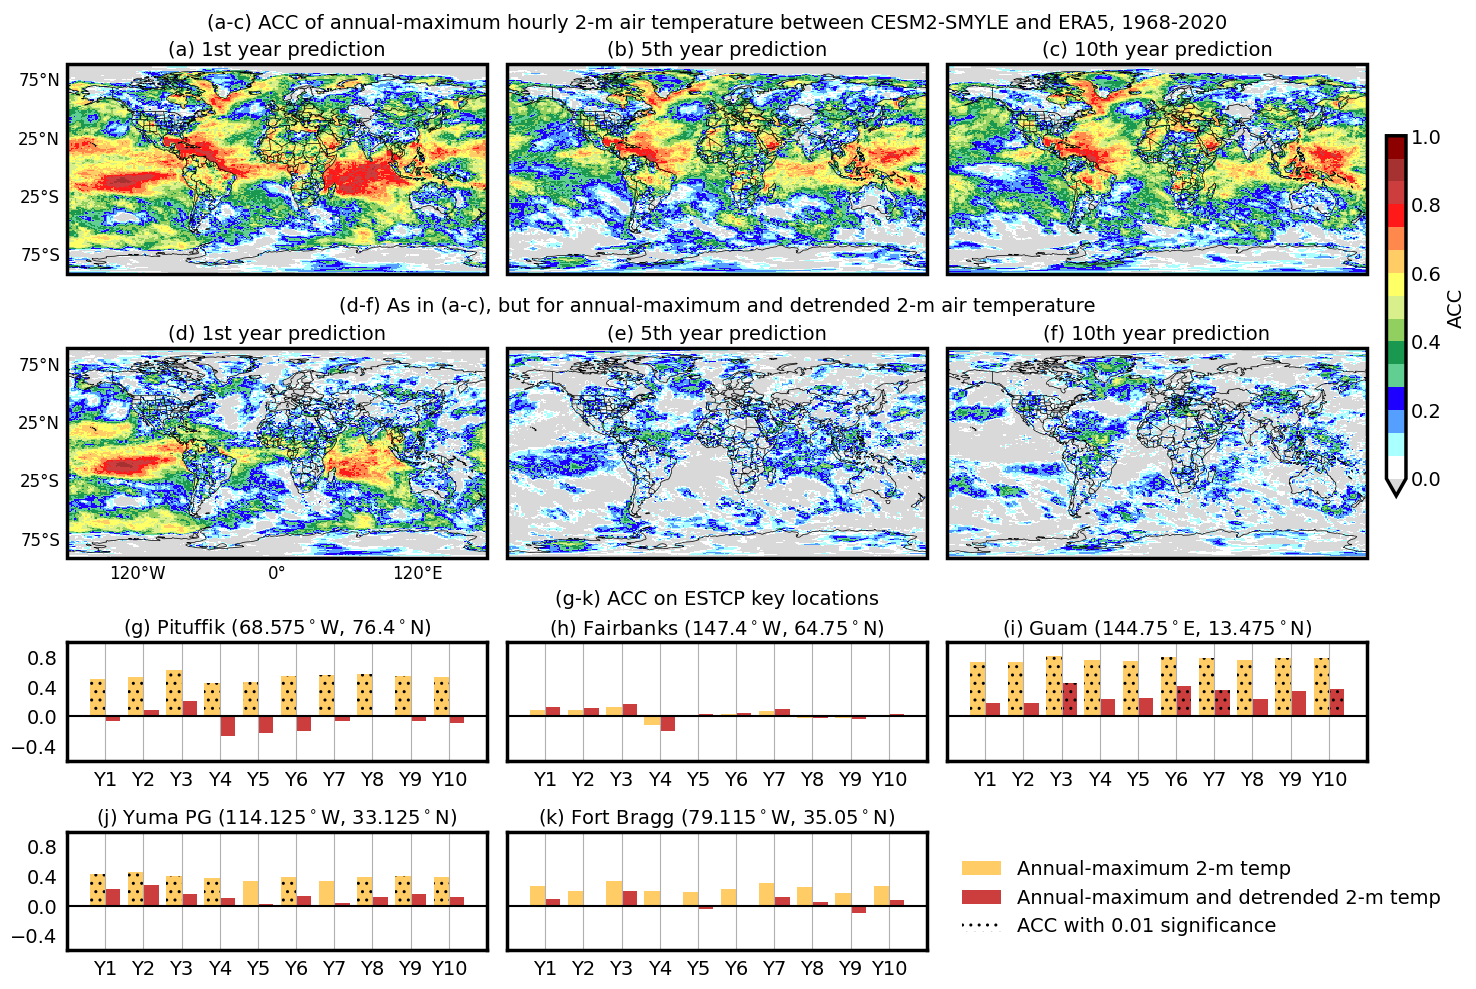

In [12]:
key = 'TREFHTMX_max'
np_ACC = ds_ACC_all[key].values
np_ACC_pval = ds_ACC_all[key+'_pval'].values
np_ACC_detrend = ds_ACC_detrend[key+'_detrend'].values
np_ACC_detrend_pval = ds_ACC_detrend[key+'_detrend_pval'].values

ds_stn = subset_stn(ds_ACC_all, key=key)
ds_stn_pval = subset_stn(ds_ACC_all, key=key+'_pval')
ds_stn_detrend = subset_stn(ds_ACC_detrend, key=key+'_detrend')
ds_stn_detrend_pval = subset_stn(ds_ACC_detrend, key=key+'_detrend_pval')

np_stn = ds_stn.values
np_stn_pval = ds_stn_pval.values
np_stn_detrend = ds_stn_detrend.values
np_stn_detrend_pval = ds_stn_detrend_pval.values

proj_ = ccrs.PlateCarree()
map_extent = [-180, 180, -90, 90]

fig = plt.figure(figsize=(13, 9))
gs = gridspec.GridSpec(7, 6, height_ratios=[1, 0.2, 1, 0.3, 0.5, 0.3, 0.5], width_ratios=[1,]*6)

AX_maps = []
AX_maps.append(plt.subplot(gs[0, 0:2], projection=proj_))
AX_maps.append(plt.subplot(gs[0, 2:4], projection=proj_))
AX_maps.append(plt.subplot(gs[0, 4:6], projection=proj_))
AX_maps.append(plt.subplot(gs[2, 0:2], projection=proj_))
AX_maps.append(plt.subplot(gs[2, 2:4], projection=proj_))
AX_maps.append(plt.subplot(gs[2, 4:6], projection=proj_))

AX_lines = []
AX_lines.append(plt.subplot(gs[4, 0:2]))
AX_lines.append(plt.subplot(gs[4, 2:4]))
AX_lines.append(plt.subplot(gs[4, 4:6]))

AX_lines.append(plt.subplot(gs[6, 0:2]))
AX_lines.append(plt.subplot(gs[6, 2:4]))

fake_x = np.arange(10)
for ax in AX_lines:
    ax = gu.ax_decorate_box(ax)
    ax.tick_params(labelbottom=True)
    ax.set_ylim([-0.6, 1])
    ax.set_yticks([-0.4, 0, 0.4, 0.8])
    ax.set_xlim(-1, fake_x[-1] + 1)
    ax.set_xticks(fake_x)
    ax.set_xticklabels(['Y1', 'Y2', 'Y3', 'Y4', 'Y5', 'Y6', 'Y7', 'Y8', 'Y9', 'Y10'])
    ax.grid(axis='x')

AX_lines[0].tick_params(labelleft=True)
AX_lines[3].tick_params(labelleft=True)

for i_ax, ax in enumerate(AX_maps):
    ax.set_extent(map_extent, crs=proj_)
    ax = map_gridline_opt(ax)
    if i_ax == 0 or i_ax == 3:
        GL = ax.gridlines(
            crs=ccrs.PlateCarree(),
            draw_labels=True, x_inline=False, y_inline=False,
            color='k', linewidth=0, linestyle=':', zorder=5
        )
        GL.top_labels = None
        GL.right_labels = None
        if i_ax == 0:
            GL.bottom_labels = None
        GL.xlabel_style = {'size': 12}
        GL.ylabel_style = {'size': 12}
        GL.xlocator = ticker.FixedLocator([-120, 0, 120])
        GL.ylocator = ticker.FixedLocator([-75, -25, 25, 75])


plt.subplots_adjust(0, 0, 1, 1, hspace=0.0, wspace=0.1)

for i_lead, lead in enumerate(leads):
    CS = AX_maps[i_lead].pcolormesh(
        lon, lat, np_ACC[lead, ...], 
        vmin=0, vmax=1.0, cmap=cmap, 
        transform=ccrs.PlateCarree()
    )

    AX_maps[3+i_lead].pcolormesh(
        lon, lat, np_ACC_detrend[lead, ...], 
        vmin=0, vmax=1.0, cmap=cmap, 
        transform=ccrs.PlateCarree()
    )
    
width = 0.40
x1 = fake_x - width/2   # left bars
x2 = fake_x + width/2   # right bars
for i_stn, stn in enumerate(stn_names):
    ax = AX_lines[i_stn]

    ax.axhline(0, xmin=0, xmax=1, linewidth=1.5, color='k', linestyle='-')
    bars1 = ax.bar(x1, np_stn[:, i_stn], width=width, color=orange, edgecolor="none")
    mask_pval = np_stn_pval[:, i_stn] < 0.01
    for rect, m in zip(bars1, mask_pval):
        if m:
            rect.set_hatch("..")
            rect.set_edgecolor("k")
            rect.set_linewidth(0.0)
            
    
    bars2 = ax.bar(x2, np_stn_detrend[:, i_stn], width=width, color=red, edgecolor="none")
    mask_detrend_pval = np_stn_detrend_pval[:, i_stn] < 0.01
    for rect, m in zip(bars2, mask_detrend_pval):
        if m:
            rect.set_hatch("..")
            rect.set_edgecolor("k")
            rect.set_linewidth(0.0)

AX_maps[0].set_title('(a) 1st year prediction', fontsize=14)
AX_maps[1].set_title('(b) 5th year prediction', fontsize=14)
AX_maps[2].set_title('(c) 10th year prediction', fontsize=14)
AX_maps[3].set_title('(d) 1st year prediction', fontsize=14)
AX_maps[4].set_title('(e) 5th year prediction', fontsize=14)
AX_maps[5].set_title('(f) 10th year prediction', fontsize=14)

ax_base = fig.add_axes([1.015, 0.505, 0.05, 0.4])#
ax_base.tick_params(
    axis='both', left=False, top=False, right=False, bottom=False, 
    labelleft=False, labeltop=False, labelright=False, labelbottom=False
)
cax = inset_axes(ax_base, width='30%', height='100%', borderpad=0, loc=2)
CBar = plt.colorbar(CS, orientation='vertical', extend='min', cax=cax) # ticks=[...]
CBar.ax.tick_params(axis='y', labelsize=14, direction='in', length=0)
CBar.outline.set_linewidth(2.5)
CBar.ax.set_ylabel('ACC', fontsize=14)

ax_title1 = fig.add_axes([0.0, 1.015, 1.0, 0.03])
ax_title1.text(
    0.5, 0.5, 
    '(a-c) ACC of annual-maximum hourly 2-m air temperature between CESM2-SMYLE and ERA5, 1968-2020', 
    fontsize=14, va='center', ha='center', transform=ax_title1.transAxes
)

ax_title2 = fig.add_axes([0.0, 0.7, 1.0, 0.03])
ax_title2.text(
    0.5, 0.5, 
    '(d-f) As in (a-c), but for annual-maximum and detrended 2-m air temperature', 
    fontsize=14, va='center', ha='center', transform=ax_title2.transAxes
)

ax_title3 = fig.add_axes([0.0, 0.375, 1.0, 0.03])
ax_title3.text(
    0.5, 0.5, 
    '(g-k) ACC on ESTCP key locations', 
    fontsize=14, va='center', ha='center', transform=ax_title3.transAxes
)

AX_lines[0].set_title('(g) Pituffik (68.575$^\circ$W, 76.4$^\circ$N)', fontsize=14)
AX_lines[1].set_title('(h) Fairbanks (147.4$^\circ$W, 64.75$^\circ$N)', fontsize=14)
AX_lines[2].set_title('(i) Guam (144.75$^\circ$E, 13.475$^\circ$N)', fontsize=14)
AX_lines[3].set_title('(j) Yuma PG (114.125$^\circ$W, 33.125$^\circ$N)', fontsize=14)
AX_lines[4].set_title('(k) Fort Bragg (79.115$^\circ$W, 35.05$^\circ$N)', fontsize=14)

handle_legneds1 = []
handle_legneds1.append(patches.Patch(facecolor=orange, linewidth=0, label=' '))
handle_legneds1.append(patches.Patch(facecolor=red, linewidth=0, label=' '))
handle_legneds1.append(patches.Patch(facecolor='none', hatch='..', linewidth=0, label=' '))

ax_lg1 = fig.add_axes([0.68, 0.01, 0.39, 0.11])
LG1 = ax_lg1.legend(
    handle_legneds1, 
    ['Annual-maximum 2-m temp', 'Annual-maximum and detrended 2-m temp', 'ACC with 0.01 significance'], 
    bbox_to_anchor=(1, 1), ncol=1, prop={'size':14}
)

LG1 = gu.lg_box(LG1)
ax_lg1.set_axis_off()
ax_base.set_axis_off()
ax_title1.set_axis_off()
ax_title2.set_axis_off()
ax_title3.set_axis_off()

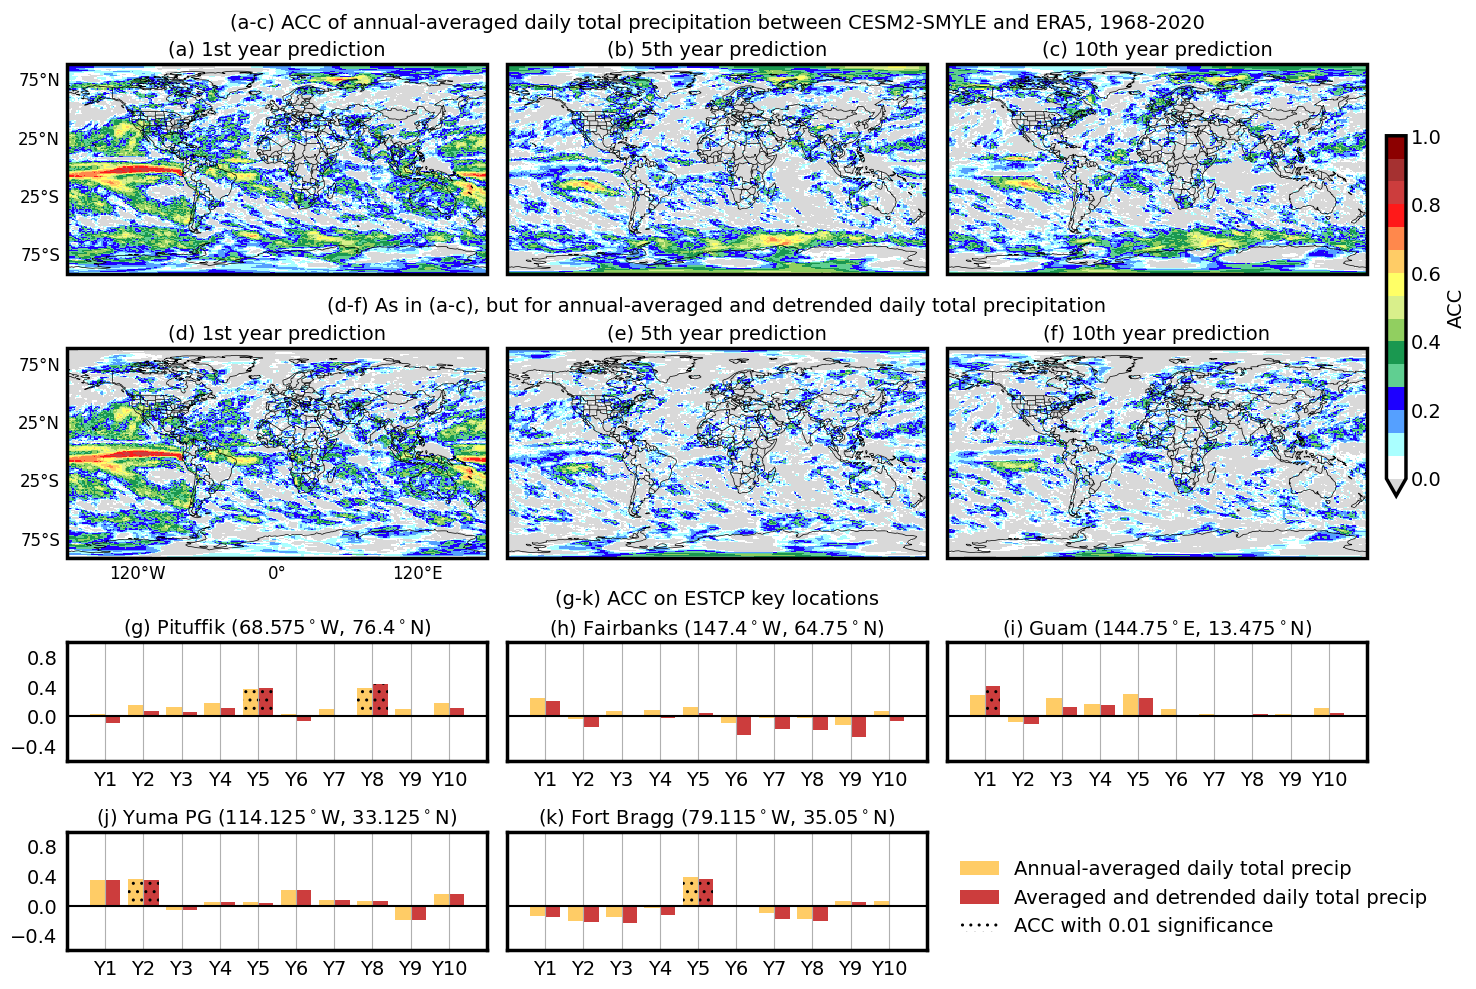

In [13]:
key = 'PRECT_mean'
np_ACC = ds_ACC_all[key].values
np_ACC_pval = ds_ACC_all[key+'_pval'].values
np_ACC_detrend = ds_ACC_detrend[key+'_detrend'].values
np_ACC_detrend_pval = ds_ACC_detrend[key+'_detrend_pval'].values

ds_stn = subset_stn(ds_ACC_all, key=key)
ds_stn_pval = subset_stn(ds_ACC_all, key=key+'_pval')
ds_stn_detrend = subset_stn(ds_ACC_detrend, key=key+'_detrend')
ds_stn_detrend_pval = subset_stn(ds_ACC_detrend, key=key+'_detrend_pval')

np_stn = ds_stn.values
np_stn_pval = ds_stn_pval.values
np_stn_detrend = ds_stn_detrend.values
np_stn_detrend_pval = ds_stn_detrend_pval.values

proj_ = ccrs.PlateCarree()
map_extent = [-180, 180, -90, 90]

fig = plt.figure(figsize=(13, 9))
gs = gridspec.GridSpec(7, 6, height_ratios=[1, 0.2, 1, 0.3, 0.5, 0.3, 0.5], width_ratios=[1,]*6)

AX_maps = []
AX_maps.append(plt.subplot(gs[0, 0:2], projection=proj_))
AX_maps.append(plt.subplot(gs[0, 2:4], projection=proj_))
AX_maps.append(plt.subplot(gs[0, 4:6], projection=proj_))
AX_maps.append(plt.subplot(gs[2, 0:2], projection=proj_))
AX_maps.append(plt.subplot(gs[2, 2:4], projection=proj_))
AX_maps.append(plt.subplot(gs[2, 4:6], projection=proj_))

AX_lines = []
AX_lines.append(plt.subplot(gs[4, 0:2]))
AX_lines.append(plt.subplot(gs[4, 2:4]))
AX_lines.append(plt.subplot(gs[4, 4:6]))

AX_lines.append(plt.subplot(gs[6, 0:2]))
AX_lines.append(plt.subplot(gs[6, 2:4]))

fake_x = np.arange(10)
for ax in AX_lines:
    ax = gu.ax_decorate_box(ax)
    ax.tick_params(labelbottom=True)
    ax.set_ylim([-0.6, 1])
    ax.set_yticks([-0.4, 0, 0.4, 0.8])
    ax.set_xlim(-1, fake_x[-1] + 1)
    ax.set_xticks(fake_x)
    ax.set_xticklabels(['Y1', 'Y2', 'Y3', 'Y4', 'Y5', 'Y6', 'Y7', 'Y8', 'Y9', 'Y10'])
    ax.grid(axis='x')

AX_lines[0].tick_params(labelleft=True)
AX_lines[3].tick_params(labelleft=True)

for i_ax, ax in enumerate(AX_maps):
    ax.set_extent(map_extent, crs=proj_)
    ax = map_gridline_opt(ax)
    if i_ax == 0 or i_ax == 3:
        GL = ax.gridlines(
            crs=ccrs.PlateCarree(),
            draw_labels=True, x_inline=False, y_inline=False,
            color='k', linewidth=0, linestyle=':', zorder=5
        )
        GL.top_labels = None
        GL.right_labels = None
        if i_ax == 0:
            GL.bottom_labels = None
        GL.xlabel_style = {'size': 12}
        GL.ylabel_style = {'size': 12}
        GL.xlocator = ticker.FixedLocator([-120, 0, 120])
        GL.ylocator = ticker.FixedLocator([-75, -25, 25, 75])


plt.subplots_adjust(0, 0, 1, 1, hspace=0.0, wspace=0.1)

for i_lead, lead in enumerate(leads):
    CS = AX_maps[i_lead].pcolormesh(
        lon, lat, np_ACC[lead, ...], 
        vmin=0, vmax=1.0, cmap=cmap, 
        transform=ccrs.PlateCarree()
    )

    AX_maps[3+i_lead].pcolormesh(
        lon, lat, np_ACC_detrend[lead, ...], 
        vmin=0, vmax=1.0, cmap=cmap, 
        transform=ccrs.PlateCarree()
    )
    
width = 0.40
x1 = fake_x - width/2   # left bars
x2 = fake_x + width/2   # right bars
for i_stn, stn in enumerate(stn_names):
    ax = AX_lines[i_stn]

    ax.axhline(0, xmin=0, xmax=1, linewidth=1.5, color='k', linestyle='-')
    bars1 = ax.bar(x1, np_stn[:, i_stn], width=width, color=orange, edgecolor="none")
    mask_pval = np_stn_pval[:, i_stn] < 0.01
    for rect, m in zip(bars1, mask_pval):
        if m:
            rect.set_hatch("..")
            rect.set_edgecolor("k")
            rect.set_linewidth(0.0)
            
    
    bars2 = ax.bar(x2, np_stn_detrend[:, i_stn], width=width, color=red, edgecolor="none")
    mask_detrend_pval = np_stn_detrend_pval[:, i_stn] < 0.01
    for rect, m in zip(bars2, mask_detrend_pval):
        if m:
            rect.set_hatch("..")
            rect.set_edgecolor("k")
            rect.set_linewidth(0.0)

AX_maps[0].set_title('(a) 1st year prediction', fontsize=14)
AX_maps[1].set_title('(b) 5th year prediction', fontsize=14)
AX_maps[2].set_title('(c) 10th year prediction', fontsize=14)
AX_maps[3].set_title('(d) 1st year prediction', fontsize=14)
AX_maps[4].set_title('(e) 5th year prediction', fontsize=14)
AX_maps[5].set_title('(f) 10th year prediction', fontsize=14)

ax_base = fig.add_axes([1.015, 0.505, 0.05, 0.4])#
ax_base.tick_params(
    axis='both', left=False, top=False, right=False, bottom=False, 
    labelleft=False, labeltop=False, labelright=False, labelbottom=False
)
cax = inset_axes(ax_base, width='30%', height='100%', borderpad=0, loc=2)
CBar = plt.colorbar(CS, orientation='vertical', extend='min', cax=cax) # ticks=[...]
CBar.ax.tick_params(axis='y', labelsize=14, direction='in', length=0)
CBar.outline.set_linewidth(2.5)
CBar.ax.set_ylabel('ACC', fontsize=14)

ax_title1 = fig.add_axes([0.0, 1.015, 1.0, 0.03])
ax_title1.text(
    0.5, 0.5, 
    '(a-c) ACC of annual-averaged daily total precipitation between CESM2-SMYLE and ERA5, 1968-2020', 
    fontsize=14, va='center', ha='center', transform=ax_title1.transAxes
)

ax_title2 = fig.add_axes([0.0, 0.7, 1.0, 0.03])
ax_title2.text(
    0.5, 0.5, 
    '(d-f) As in (a-c), but for annual-averaged and detrended daily total precipitation', 
    fontsize=14, va='center', ha='center', transform=ax_title2.transAxes
)

ax_title3 = fig.add_axes([0.0, 0.375, 1.0, 0.03])
ax_title3.text(
    0.5, 0.5, 
    '(g-k) ACC on ESTCP key locations', 
    fontsize=14, va='center', ha='center', transform=ax_title3.transAxes
)

AX_lines[0].set_title('(g) Pituffik (68.575$^\circ$W, 76.4$^\circ$N)', fontsize=14)
AX_lines[1].set_title('(h) Fairbanks (147.4$^\circ$W, 64.75$^\circ$N)', fontsize=14)
AX_lines[2].set_title('(i) Guam (144.75$^\circ$E, 13.475$^\circ$N)', fontsize=14)
AX_lines[3].set_title('(j) Yuma PG (114.125$^\circ$W, 33.125$^\circ$N)', fontsize=14)
AX_lines[4].set_title('(k) Fort Bragg (79.115$^\circ$W, 35.05$^\circ$N)', fontsize=14)

handle_legneds1 = []
handle_legneds1.append(patches.Patch(facecolor=orange, linewidth=0, label=' '))
handle_legneds1.append(patches.Patch(facecolor=red, linewidth=0, label=' '))
handle_legneds1.append(patches.Patch(facecolor='none', hatch='..', linewidth=0, label=' '))

ax_lg1 = fig.add_axes([0.68, 0.01, 0.38, 0.11])
LG1 = ax_lg1.legend(
    handle_legneds1, 
    ['Annual-averaged daily total precip', 'Averaged and detrended daily total precip', 'ACC with 0.01 significance'],
    bbox_to_anchor=(1, 1), ncol=1, prop={'size':14}
)

LG1 = gu.lg_box(LG1)
ax_lg1.set_axis_off()
ax_base.set_axis_off()
ax_title1.set_axis_off()
ax_title2.set_axis_off()
ax_title3.set_axis_off()

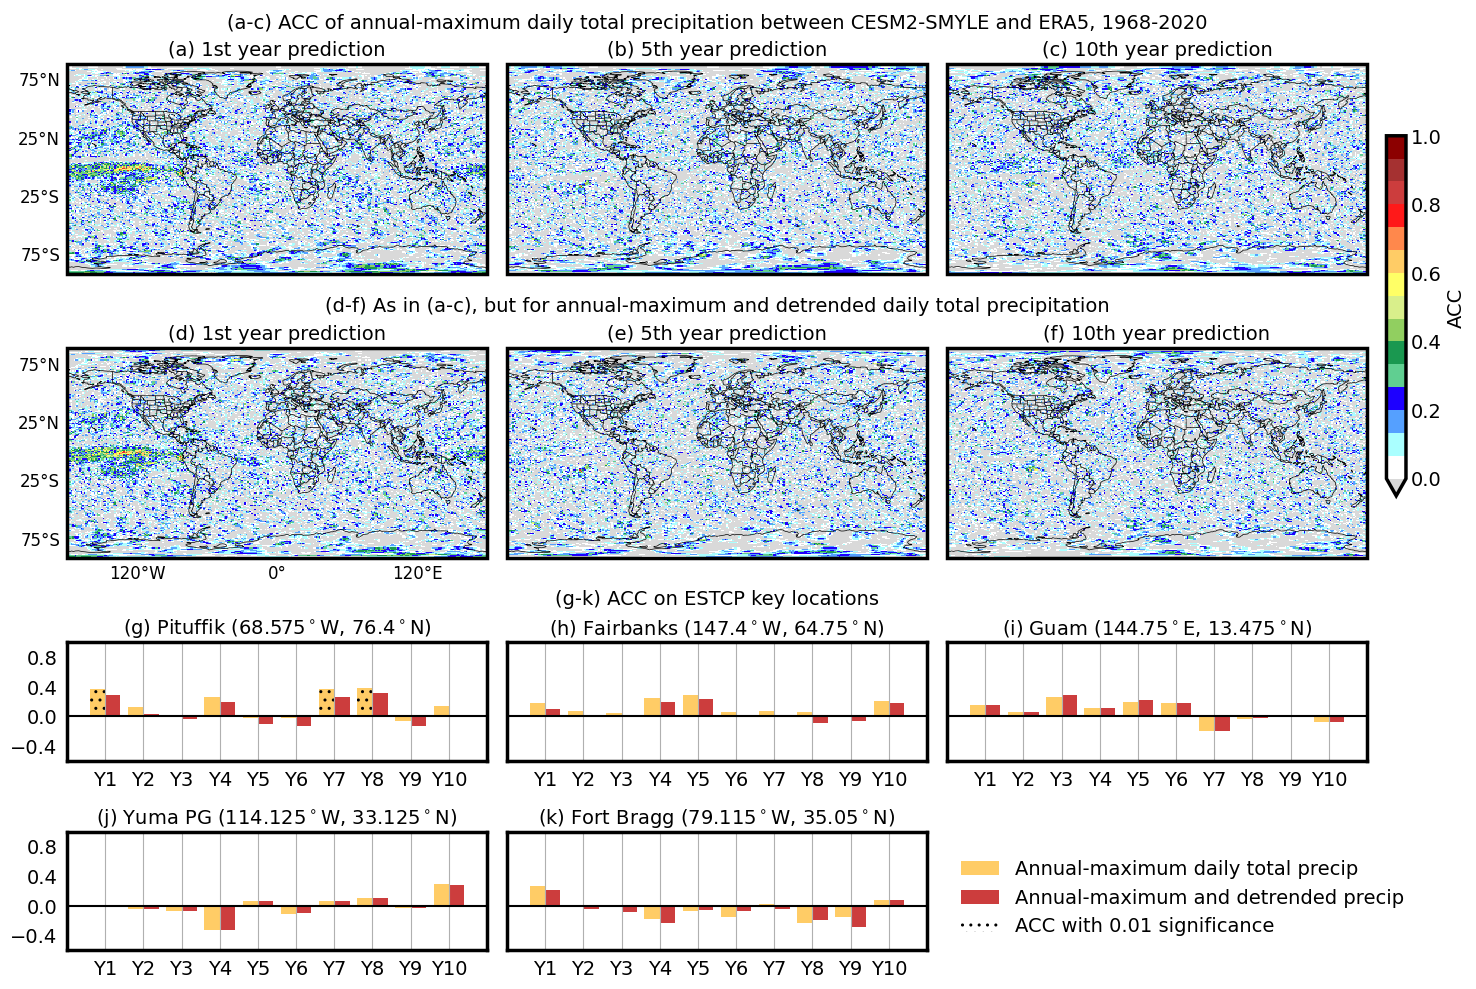

In [14]:
key = 'PRECT_max'
np_ACC = ds_ACC_all[key].values
np_ACC_pval = ds_ACC_all[key+'_pval'].values
np_ACC_detrend = ds_ACC_detrend[key+'_detrend'].values
np_ACC_detrend_pval = ds_ACC_detrend[key+'_detrend_pval'].values

ds_stn = subset_stn(ds_ACC_all, key=key)
ds_stn_pval = subset_stn(ds_ACC_all, key=key+'_pval')
ds_stn_detrend = subset_stn(ds_ACC_detrend, key=key+'_detrend')
ds_stn_detrend_pval = subset_stn(ds_ACC_detrend, key=key+'_detrend_pval')

np_stn = ds_stn.values
np_stn_pval = ds_stn_pval.values
np_stn_detrend = ds_stn_detrend.values
np_stn_detrend_pval = ds_stn_detrend_pval.values

proj_ = ccrs.PlateCarree()
map_extent = [-180, 180, -90, 90]

fig = plt.figure(figsize=(13, 9))
gs = gridspec.GridSpec(7, 6, height_ratios=[1, 0.2, 1, 0.3, 0.5, 0.3, 0.5], width_ratios=[1,]*6)

AX_maps = []
AX_maps.append(plt.subplot(gs[0, 0:2], projection=proj_))
AX_maps.append(plt.subplot(gs[0, 2:4], projection=proj_))
AX_maps.append(plt.subplot(gs[0, 4:6], projection=proj_))
AX_maps.append(plt.subplot(gs[2, 0:2], projection=proj_))
AX_maps.append(plt.subplot(gs[2, 2:4], projection=proj_))
AX_maps.append(plt.subplot(gs[2, 4:6], projection=proj_))

AX_lines = []
AX_lines.append(plt.subplot(gs[4, 0:2]))
AX_lines.append(plt.subplot(gs[4, 2:4]))
AX_lines.append(plt.subplot(gs[4, 4:6]))

AX_lines.append(plt.subplot(gs[6, 0:2]))
AX_lines.append(plt.subplot(gs[6, 2:4]))

fake_x = np.arange(10)
for ax in AX_lines:
    ax = gu.ax_decorate_box(ax)
    ax.tick_params(labelbottom=True)
    ax.set_ylim([-0.6, 1])
    ax.set_yticks([-0.4, 0, 0.4, 0.8])
    ax.set_xlim(-1, fake_x[-1] + 1)
    ax.set_xticks(fake_x)
    ax.set_xticklabels(['Y1', 'Y2', 'Y3', 'Y4', 'Y5', 'Y6', 'Y7', 'Y8', 'Y9', 'Y10'])
    ax.grid(axis='x')

AX_lines[0].tick_params(labelleft=True)
AX_lines[3].tick_params(labelleft=True)

for i_ax, ax in enumerate(AX_maps):
    ax.set_extent(map_extent, crs=proj_)
    ax = map_gridline_opt(ax)
    if i_ax == 0 or i_ax == 3:
        GL = ax.gridlines(
            crs=ccrs.PlateCarree(),
            draw_labels=True, x_inline=False, y_inline=False,
            color='k', linewidth=0, linestyle=':', zorder=5
        )
        GL.top_labels = None
        GL.right_labels = None
        if i_ax == 0:
            GL.bottom_labels = None
        GL.xlabel_style = {'size': 12}
        GL.ylabel_style = {'size': 12}
        GL.xlocator = ticker.FixedLocator([-120, 0, 120])
        GL.ylocator = ticker.FixedLocator([-75, -25, 25, 75])


plt.subplots_adjust(0, 0, 1, 1, hspace=0.0, wspace=0.1)

for i_lead, lead in enumerate(leads):
    CS = AX_maps[i_lead].pcolormesh(
        lon, lat, np_ACC[lead, ...], 
        vmin=0, vmax=1.0, cmap=cmap, 
        transform=ccrs.PlateCarree()
    )

    AX_maps[3+i_lead].pcolormesh(
        lon, lat, np_ACC_detrend[lead, ...], 
        vmin=0, vmax=1.0, cmap=cmap, 
        transform=ccrs.PlateCarree()
    )
    
width = 0.40
x1 = fake_x - width/2   # left bars
x2 = fake_x + width/2   # right bars
for i_stn, stn in enumerate(stn_names):
    ax = AX_lines[i_stn]

    ax.axhline(0, xmin=0, xmax=1, linewidth=1.5, color='k', linestyle='-')
    bars1 = ax.bar(x1, np_stn[:, i_stn], width=width, color=orange, edgecolor="none")
    mask_pval = np_stn_pval[:, i_stn] < 0.01
    for rect, m in zip(bars1, mask_pval):
        if m:
            rect.set_hatch("..")
            rect.set_edgecolor("k")
            rect.set_linewidth(0.0)
            
    
    bars2 = ax.bar(x2, np_stn_detrend[:, i_stn], width=width, color=red, edgecolor="none")
    mask_detrend_pval = np_stn_detrend_pval[:, i_stn] < 0.01
    for rect, m in zip(bars2, mask_detrend_pval):
        if m:
            rect.set_hatch("..")
            rect.set_edgecolor("k")
            rect.set_linewidth(0.0)

AX_maps[0].set_title('(a) 1st year prediction', fontsize=14)
AX_maps[1].set_title('(b) 5th year prediction', fontsize=14)
AX_maps[2].set_title('(c) 10th year prediction', fontsize=14)
AX_maps[3].set_title('(d) 1st year prediction', fontsize=14)
AX_maps[4].set_title('(e) 5th year prediction', fontsize=14)
AX_maps[5].set_title('(f) 10th year prediction', fontsize=14)

ax_base = fig.add_axes([1.015, 0.505, 0.05, 0.4])#
ax_base.tick_params(
    axis='both', left=False, top=False, right=False, bottom=False, 
    labelleft=False, labeltop=False, labelright=False, labelbottom=False
)
cax = inset_axes(ax_base, width='30%', height='100%', borderpad=0, loc=2)
CBar = plt.colorbar(CS, orientation='vertical', extend='min', cax=cax) # ticks=[...]
CBar.ax.tick_params(axis='y', labelsize=14, direction='in', length=0)
CBar.outline.set_linewidth(2.5)
CBar.ax.set_ylabel('ACC', fontsize=14)

ax_title1 = fig.add_axes([0.0, 1.015, 1.0, 0.03])
ax_title1.text(
    0.5, 0.5, 
    '(a-c) ACC of annual-maximum daily total precipitation between CESM2-SMYLE and ERA5, 1968-2020', 
    fontsize=14, va='center', ha='center', transform=ax_title1.transAxes
)

ax_title2 = fig.add_axes([0.0, 0.7, 1.0, 0.03])
ax_title2.text(
    0.5, 0.5, 
    '(d-f) As in (a-c), but for annual-maximum and detrended daily total precipitation', 
    fontsize=14, va='center', ha='center', transform=ax_title2.transAxes
)

ax_title3 = fig.add_axes([0.0, 0.375, 1.0, 0.03])
ax_title3.text(
    0.5, 0.5, 
    '(g-k) ACC on ESTCP key locations', 
    fontsize=14, va='center', ha='center', transform=ax_title3.transAxes
)

AX_lines[0].set_title('(g) Pituffik (68.575$^\circ$W, 76.4$^\circ$N)', fontsize=14)
AX_lines[1].set_title('(h) Fairbanks (147.4$^\circ$W, 64.75$^\circ$N)', fontsize=14)
AX_lines[2].set_title('(i) Guam (144.75$^\circ$E, 13.475$^\circ$N)', fontsize=14)
AX_lines[3].set_title('(j) Yuma PG (114.125$^\circ$W, 33.125$^\circ$N)', fontsize=14)
AX_lines[4].set_title('(k) Fort Bragg (79.115$^\circ$W, 35.05$^\circ$N)', fontsize=14)

handle_legneds1 = []
handle_legneds1.append(patches.Patch(facecolor=orange, linewidth=0, label=' '))
handle_legneds1.append(patches.Patch(facecolor=red, linewidth=0, label=' '))
handle_legneds1.append(patches.Patch(facecolor='none', hatch='..', linewidth=0, label=' '))

ax_lg1 = fig.add_axes([0.68, 0.01, 0.362, 0.11])
LG1 = ax_lg1.legend(
    handle_legneds1, 
    ['Annual-maximum daily total precip', 'Annual-maximum and detrended precip', 'ACC with 0.01 significance'],
    bbox_to_anchor=(1, 1), ncol=1, prop={'size':14}
)

LG1 = gu.lg_box(LG1)
ax_lg1.set_axis_off()
ax_base.set_axis_off()
ax_title1.set_axis_off()
ax_title2.set_axis_off()
ax_title3.set_axis_off()